In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from AnalyticCoolingCurves import *
from unpackConfigurations import unpackConfiguration
from unpackConfigurationsMK import unpackConfigurationMK
import ThermalFrontFormulation as TF
from matplotlib.collections import LineCollection
import os
import pickle as pkl
from LRBv2 import LRBv2
from LRBv21 import LRBv21
import matplotlib as mpl
import copy
from LengyelReinkeFormulation import *
import ThermalFrontFormulation as TF
import colorcet as cc
from scipy import interpolate
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, MultipleLocator, FormatStrFormatter, AutoMinorLocator

from DLScommonTools import *

%load_ext autoreload
%autoreload 2

set_matplotlib_defaults()



# IO

In [2]:
file_paths = {
    "V10" : r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc",
     "V10X" : r"C:\Users\Mike\OneDrive\Project\DLS\from_sarah\V10Xgluedgrid_balance\balance.nc",
     "SPR38" : r"C:\Users\Mike\OneDrive\Project\DLS\STEP_SPR038\drsep0mm\balance_SPR038.nc"}

designs = file_paths.keys()
sepadd = 2
eqb = dict()

for side in ["iu", "ou"]:
    eqb[side] = dict()
    
    for design in designs:    
        eqb[side][design] = unpackConfigurationMK(File = file_paths[design], Type = side, sepadd=sepadd, resolution = 5000)

In [3]:
#set switches
radios_default = {
    "ionisation": False,  # in development
    "upstreamGrid": True, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, #upstream density
    "nu0" : 1e20,
    "cz0" : 0.02,
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncKallenbachAr, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


# KallenbachAr

In [167]:
list_Lc_scales

array([0.5  , 0.625, 0.75 , 0.875, 1.   , 1.25 , 1.5  , 1.75 , 2.   ])

# Density

In [87]:
ne_kAr = dict()
store = ne_kAr

design = "SPR38"

list_BxBt_scales = np.append(np.linspace(0.5, 1.0, 5), np.linspace(1.0, 2.0, 5)[1:])
list_Lc_scales = np.append(np.linspace(0.5, 1.0, 5), np.linspace(1.0, 2.0, 5)[1:])

for side in ["iu", "ou"]:
    print("Running side: {}".format(side))
    result_array = []
    
    for i, BxBt_scale in enumerate(list_BxBt_scales):
        print("Running BxBt scale factor: {:.2f} -- ".format(BxBt_scale), end="")
        result_row = []
        
        for j, Lc_scale in enumerate(list_Lc_scales):
            print("Running Lc scale factor: {:.2f} -- ".format(Lc_scale), end="")
                
            d = copy.deepcopy(eqb[side][design])
            constants = constants_default.copy()
            radios = radios_default.copy()
                              
            d["Btot"] = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = BxBt_scale)
            d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = Lc_scale)
                              
            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["cz0"] = 0.05
            
            # SPR38:
            # 0.11: failed at 0.50/0.50
            # 0.1: failed at 0.50/0.88
            # 0.09: failed at 0.50/0.88
            # 0.085: failed at 0.50/0.50
            # 0.02: failed at 0.50/0.50
            # 0.001: failed at 0.50/0.50
            
            # V10:
            # 0.06: failed at 0.5:0.50
            # 0.07: failed at 0.5:0.50
            # 0.08: failed at 1.5/0.62
            # 0.085: SUCCESS
            # 0.09: failed at 1.0/1.25 x2
            # 0.10: failed at 1.25/0.62
            # 0.11: failed at 1.25/0.62
            
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

            # SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 3)
            # indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]
            indexRange = [0, d["Xpoint"]-1]
            
            constants["Lfunc"] = LfuncKallenbachAr        
            out = LRBv21(constants,radios,d["S"],d["Spol"],indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = "power")

            out["SpolPlot"] = [d["Spol"][x] for x in indexRange]
            result_row.append(out)

        result_array.append(result_row)
                              
    store[side] = result_array


Running side: iu
Running BxBt scale factor: 0.50 -- Running Lc scale factor: 0.50 -- Solving...0...

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:62: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


54...Complete in 5.4 seconds
Running Lc scale factor: 0.62 -- Solving...0...54...Complete in 5.7 seconds
Running Lc scale factor: 0.75 -- Solving...0...54...Complete in 5.2 seconds
Running Lc scale factor: 0.88 -- Solving...0...54...Complete in 5.3 seconds
Running Lc scale factor: 1.00 -- Solving...0...54...Complete in 5.2 seconds
Running Lc scale factor: 1.25 -- Solving...0...54...Complete in 5.0 seconds
Running Lc scale factor: 1.50 -- Solving...0...54...Complete in 4.3 seconds
Running Lc scale factor: 1.75 -- Solving...0...54...Complete in 5.5 seconds
Running Lc scale factor: 2.00 -- Solving...0...54...Complete in 6.8 seconds
Running BxBt scale factor: 0.62 -- Running Lc scale factor: 0.50 -- Solving...0...54...Complete in 5.4 seconds
Running Lc scale factor: 0.62 -- Solving...0...54...Complete in 5.2 seconds
Running Lc scale factor: 0.75 -- Solving...0...54...Complete in 4.9 seconds
Running Lc scale factor: 0.88 -- Solving...0...54...Complete in 4.8 seconds
Running Lc scale factor:

C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


54...Complete in 5.8 seconds
Running Lc scale factor: 0.75 -- Solving...0...54...Complete in 5.0 seconds
Running Lc scale factor: 0.88 -- Solving...0...54...Complete in 4.4 seconds
Running Lc scale factor: 1.00 -- Solving...0...54...Complete in 5.5 seconds
Running Lc scale factor: 1.25 -- Solving...0...54...Complete in 5.4 seconds
Running Lc scale factor: 1.50 -- Solving...0...54...Complete in 5.5 seconds
Running Lc scale factor: 1.75 -- Solving...0...54...Complete in 4.0 seconds
Running Lc scale factor: 2.00 -- Solving...0...54...Complete in 4.6 seconds
Running BxBt scale factor: 2.00 -- Running Lc scale factor: 0.50 -- Solving...0...54...Complete in 5.2 seconds
Running Lc scale factor: 0.62 -- Solving...0...54...Complete in 5.4 seconds
Running Lc scale factor: 0.75 -- Solving...0...54...Complete in 5.7 seconds
Running Lc scale factor: 0.88 -- Solving...0...54...Complete in 4.7 seconds
Running Lc scale factor: 1.00 -- Solving...0...54...Complete in 5.3 seconds
Running Lc scale factor:

In [88]:
file_write(ne_kAr, "2dscans_V10_q_kAr.pkl")

In [66]:
arr["ou"]["window_ratio_norm"][4,:]

array([-0.20011487, -0.14362956, -0.09367134, -0.04399688,  0.        ,
        0.08845217,  0.17056121,  0.24602337,  0.32076571])

# Density wider scan

In [8]:
store = dict()

design = "V10"

list_BxBt_scales2 = np.append(np.linspace(0.25, 1.0, 7), np.linspace(1.0, 2.5, 7)[1:])
list_Lc_scales2 = np.append(np.linspace(0.25, 1.0, 7), np.linspace(1.0, 2.5, 7)[1:])

for side in ["iu", "ou"]:
    print("Running side: {}".format(side))
    result_array = []
    
    for i, BxBt_scale in enumerate(list_BxBt_scales2):
        print("Running BxBt scale factor: {:.2f} -- ".format(BxBt_scale), end="")
        result_row = []
        
        for j, Lc_scale in enumerate(list_Lc_scales2):
            print("Running Lc scale factor: {:.2f} -- ".format(Lc_scale), end="")
                
            d = copy.deepcopy(eqb[side][design])
            constants = constants_default.copy()
            radios = radios_default.copy()
                              
            d["Btot"] = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = BxBt_scale)
            d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = Lc_scale)
                              
            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            
            if side == "iu":
                constants["qpllu0"] = 1e8
            elif side == "ou":
                constants["qpllu0"] = 1e9
            
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

            # SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 3)
            # indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]
            indexRange = [0, d["Xpoint"]-1]
            
            constants["Lfunc"] = LfuncKallenbachAr        
            out = LRBv21(constants,radios,d["S"],d["Spol"],indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = "power")
            result_row.append(out)

        result_array.append(result_row)
                              
    store[side] = result_array

store["list_BxBt_scales"] = list_BxBt_scales2
store["list_Lc_scales"] = list_Lc_scales2



Running side: iu
Running BxBt scale factor: 0.25 -- Running Lc scale factor: 0.25 -- Solving...0...557...Complete in 3.9 seconds
Running Lc scale factor: 0.38 -- Solving...0...557...Complete in 3.6 seconds
Running Lc scale factor: 0.50 -- Solving...0...557...Complete in 4.0 seconds
Running Lc scale factor: 0.62 -- Solving...0...557...Complete in 4.4 seconds
Running Lc scale factor: 0.75 -- Solving...0...557...Complete in 4.3 seconds
Running Lc scale factor: 0.88 -- Solving...0...557...Complete in 4.3 seconds
Running Lc scale factor: 1.00 -- Solving...0...557...Complete in 4.2 seconds
Running Lc scale factor: 1.25 -- Solving...0...557...Complete in 3.8 seconds
Running Lc scale factor: 1.50 -- Solving...0...557...Complete in 3.7 seconds
Running Lc scale factor: 1.75 -- Solving...0...557...Complete in 3.6 seconds
Running Lc scale factor: 2.00 -- Solving...0...557...Complete in 3.9 seconds
Running Lc scale factor: 2.25 -- Solving...0...557...Complete in 4.0 seconds
Running Lc scale factor:

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:62: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


557...Complete in 4.2 seconds
Running Lc scale factor: 0.38 -- Solving...0...557...Complete in 4.0 seconds
Running Lc scale factor: 0.50 -- Solving...0...557...Complete in 4.0 seconds
Running Lc scale factor: 0.62 -- Solving...0...557...Complete in 4.1 seconds
Running Lc scale factor: 0.75 -- Solving...0...557...Complete in 4.1 seconds
Running Lc scale factor: 0.88 -- Solving...0...557...Complete in 4.0 seconds
Running Lc scale factor: 1.00 -- Solving...0...557...Complete in 4.0 seconds
Running Lc scale factor: 1.25 -- Solving...0...557...Complete in 3.8 seconds
Running Lc scale factor: 1.50 -- Solving...0...557...Complete in 3.9 seconds
Running Lc scale factor: 1.75 -- Solving...0...557...Complete in 3.3 seconds
Running Lc scale factor: 2.00 -- Solving...0...557...Complete in 4.5 seconds
Running Lc scale factor: 2.25 -- Solving...0...557...Complete in 4.0 seconds
Running Lc scale factor: 2.50 -- Solving...0...557...Complete in 4.1 seconds
Running BxBt scale factor: 1.50 -- Running Lc 

In [9]:
file_write(store, "2dscans_V10_q_kAr_wide_innerloq.pkl")

# Fine scan

In [4]:
np.append(np.linspace(0.75, 1.0, 7), np.linspace(1.0, 2.5, 7)[1:])

array([0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   , 1.25 , 1.5  ,
       1.75 , 2.   , 2.25 , 2.5  ])

In [8]:
store = dict()

design = "V10"

list_BxBt_scales2 = np.append(np.linspace(0.25, 1.0, 7), np.linspace(1.0, 2.5, 7)[1:])
list_Lc_scales2 = np.append(np.linspace(0.25, 1.0, 7), np.linspace(1.0, 2.5, 7)[1:])

for side in ["iu", "ou"]:
    print("Running side: {}".format(side))
    result_array = []
    
    for i, BxBt_scale in enumerate(list_BxBt_scales2):
        print("Running BxBt scale factor: {:.2f} -- ".format(BxBt_scale), end="")
        result_row = []
        
        for j, Lc_scale in enumerate(list_Lc_scales2):
            print("Running Lc scale factor: {:.2f} -- ".format(Lc_scale), end="")
                
            d = copy.deepcopy(eqb[side][design])
            constants = constants_default.copy()
            radios = radios_default.copy()
                              
            d["Btot"] = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = BxBt_scale)
            d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = Lc_scale)
                              
            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            
            if side == "iu":
                constants["qpllu0"] = 1e8
            elif side == "ou":
                constants["qpllu0"] = 1e9
            
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

            # SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 3)
            # indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]
            indexRange = [0, d["Xpoint"]-1]
            
            constants["Lfunc"] = LfuncKallenbachAr        
            out = LRBv21(constants,radios,d["S"],d["Spol"],indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = "density")
            result_row.append(out)

        result_array.append(result_row)
                              
    store[side] = result_array

store["list_BxBt_scales"] = list_BxBt_scales2
store["list_Lc_scales"] = list_Lc_scales2



Running side: iu
Running BxBt scale factor: 0.25 -- Running Lc scale factor: 0.25 -- Solving...0...529...Complete in 3.1 seconds
Running Lc scale factor: 0.38 -- Solving...0...529...Complete in 3.2 seconds
Running Lc scale factor: 0.50 -- Solving...0...529...Complete in 2.7 seconds
Running Lc scale factor: 0.62 -- Solving...0...529...Complete in 3.4 seconds
Running Lc scale factor: 0.75 -- Solving...0...529...Complete in 3.4 seconds
Running Lc scale factor: 0.88 -- Solving...0...529...Complete in 3.1 seconds
Running Lc scale factor: 1.00 -- Solving...0...529...Complete in 3.2 seconds
Running Lc scale factor: 1.25 -- Solving...0...529...

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:62: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Complete in 3.6 seconds
Running Lc scale factor: 1.50 -- Solving...0...529...Complete in 3.4 seconds
Running Lc scale factor: 1.75 -- Solving...0...529...Complete in 3.3 seconds
Running Lc scale factor: 2.00 -- Solving...0...529...Complete in 3.4 seconds
Running Lc scale factor: 2.25 -- Solving...0...529...Complete in 3.6 seconds
Running Lc scale factor: 2.50 -- Solving...0...529...Complete in 3.8 seconds
Running BxBt scale factor: 0.38 -- Running Lc scale factor: 0.25 -- Solving...0...529...Complete in 3.4 seconds
Running Lc scale factor: 0.38 -- Solving...0...529...Complete in 3.4 seconds
Running Lc scale factor: 0.50 -- Solving...0...529...Complete in 3.2 seconds
Running Lc scale factor: 0.62 -- Solving...0...529...Complete in 3.7 seconds
Running Lc scale factor: 0.75 -- Solving...0...529...Complete in 3.7 seconds
Running Lc scale factor: 0.88 -- Solving...0...529...Complete in 3.7 seconds
Running Lc scale factor: 1.00 -- Solving...0...529...Complete in 3.7 seconds
Running Lc scale 

Text(0.5, 1.0, 'Outer divertor power window')

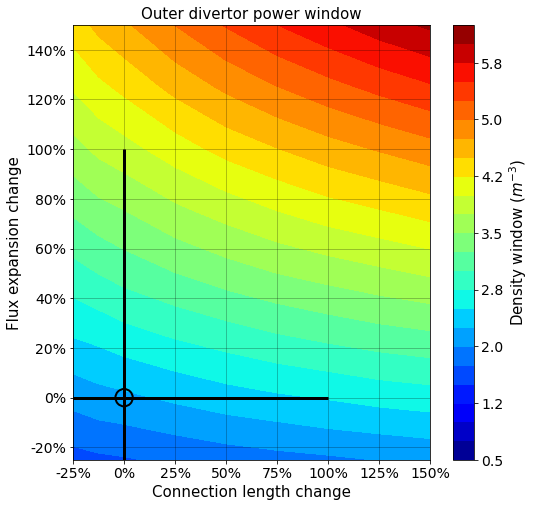

In [104]:
arr = make_arrays(ne_kAr_wide["ou"], list_BxBt_scales2, list_Lc_scales2)

fig, ax = plt.subplots(figsize = (8,8))

cmap = copy.copy(plt.get_cmap("jet"))

# levels = np.linspace(0, 3.0e19,22)
# levels = np.arange(-0.5, 0.55, 0.05)

cs = ax.contourf(list_Lc_scales2-1, list_BxBt_scales2-1, arr["window_ratio"], levels = 22, cmap = cmap, zorder = 0)
ax.grid(color = "black", alpha = 0.3)
ax.set_xlim(-0.25,1.5)
ax.set_ylim(-0.25,1.5)

ax.scatter(0,0, marker = "o", s = 300, facecolor = "None", linewidth = 2, color = "black")

cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Relative density window ($m^{-3}$)", size = 15)
cb.ax.set_yticklabels(["{:.1f}".format(i) for i in cb.get_ticks()]) 

ax.hlines(0, -0.5, 1, color = "black", zorder = 2)
ax.vlines(0, -0.5, 1, color = "black", zorder = 2)
# ax.hlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)
# ax.vlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)

ax.set_xlabel("Connection length change", fontsize = 15)
ax.set_ylabel("Flux expansion change", fontsize = 15)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_title("Outer divertor power window", fontsize = 15)

# Old

In [6]:
def patch_array(array, percentile_threshold):
    # Take 2D numpy array
    # Take out values above threshold and replace with interpolated ones
    # https://stackoverflow.com/questions/37662180/interpolate-missing-values-2d-python

    original = array.copy()
    x = list_BxBt_scales
    y = list_Lc_scales

    # original[original > threshold] = np.nan
    original[original > np.percentile(original, percentile_threshold)] = np.nan
    print("Eliminated {} values.".format(len(original[original > np.percentile(original, percentile_threshold)])))

    original = np.ma.masked_invalid(original)
    xx, yy = np.meshgrid(x,y)

    x1 = xx[~original.mask]
    y1 = yy[~original.mask]

    new = original[~original.mask]

    filled = interpolate.griddata((x1, y1), new.ravel(), (xx,yy), method = "cubic")
    return filled